In [1]:
# ignore future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import json
import pandas as pd 
import numpy as np
import time
import math
import datetime as dt
import httplib2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import seaborn as sns
import pandas_gbq

from keras.models import Sequential
from keras.layers import Dense,  Activation
from keras.layers import LSTM
from pandas import DataFrame
from numpy import concatenate

import xgboost as xgb


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

## Objective:

### Enhance driver performance by high demand suggestion.
- Build up a model forecasting location&time-based high demand.
- Complete a demo heatmap visualization based on model results.

### Extract data
- Sử dụng data HAN từ 2018-01-01 đến 2019-08-31
- timebin 10 min

In [2]:
df=pd.read_parquet('./data_hex.parquet')
df['hour']=df.timebin.dt.strftime('%H')
df['minute']=df.timebin.dt.strftime('%M')
df['dow']=df.timebin.dt.strftime('%w')
df['ss']=df['hour'].astype('float64')*60+df['minute'].astype('float64')
df=df.sort_values('timebin')
df['order_next']=df['orders'].shift(-1)
df1=df[df.timebin>='2018-01-01']

In [4]:
df1.tail()

,timebin,hex_id,orders,accept,cancel,cancel_by_user,distance,active_user,order_all,hour,minute,dow,ss,order_next
1303620,2019-08-22 23:20:00,87415cb6affffff,2,1,1,1,5.20,1,6,23,20,4,1400.0,3.0
1303621,2019-08-22 23:30:00,87415cb48ffffff,3,2,2,2,10.91,2,6,23,30,4,1410.0,2.0
1303622,2019-08-22 23:30:00,87415cb4affffff,2,1,1,1,8.75,2,6,23,30,4,1410.0,1.0
1303623,2019-08-22 23:30:00,87415cb4cffffff,1,0,1,1,6.41,1,6,23,30,4,1410.0,1.0
1303625,2019-08-22 23:40:00,87415cb4cffffff,1,0,1,1,6.41,1,2,23,40,4,1420.0,NaN


#### Có 327 hex ở HAN. tập trung xử lý với các hex có order >10000 đơn (từ 1/7/2019- 20/8/2019). Sẽ có khoảng 21 hex chứa 118k order (chiếm 93% tổng order của cả thành phố)

#### EDA

In [7]:
corr=df1.corr()
corr

,orders,accept,cancel,cancel_by_user,distance,active_user,order_all,ss,order_next
orders,1.000000,0.984830,0.765339,0.758228,0.979883,0.992268,0.461000,-0.043466,0.177046
accept,0.984830,1.000000,0.653565,0.655880,0.964621,0.984920,0.457207,-0.055855,0.175441
cancel,0.765339,0.653565,1.000000,0.961773,0.755950,0.730681,0.344278,0.012484,0.133641
cancel_by_user,0.758228,0.655880,0.961773,1.000000,0.746556,0.723654,0.332973,0.019082,0.128990
distance,0.979883,0.964621,0.755950,0.746556,1.000000,0.970619,0.495428,-0.060911,0.194520
active_user,0.992268,0.984920,0.730681,0.723654,0.970619,1.000000,0.462454,-0.044451,0.177509
order_all,0.461000,0.457207,0.344278,0.332973,0.495428,0.462454,1.000000,-0.096372,0.460430
ss,-0.043466,-0.055855,0.012484,0.019082,-0.060911,-0.044451,-0.096372,1.000000,-0.044889
order_next,0.177046,0.175441,0.133641,0.128990,0.194520,0.177509,0.460430,-0.044889,1.000000


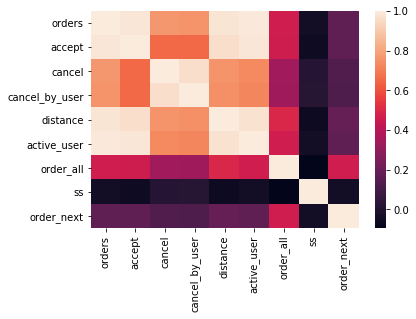

In [10]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Bỏ feature: active_user, accept, cancel by user

In [12]:
df2=df1.groupby('hex_id').agg({'orders':'sum'}).reset_index()

In [16]:
df2=df2.sort_values('orders')

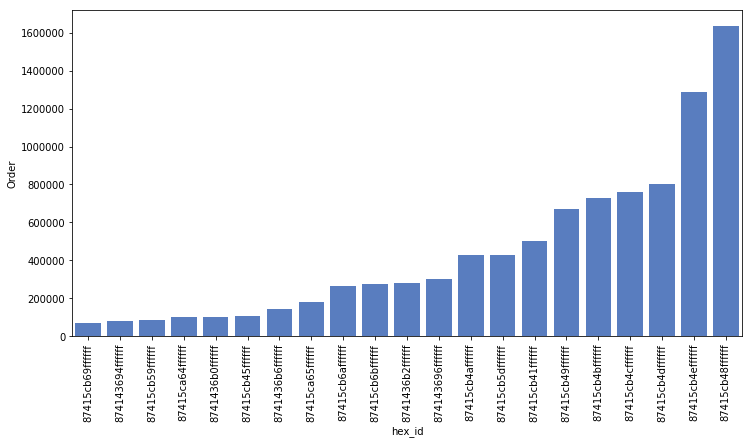

In [17]:
f, ax =plt.subplots(figsize=(12,6))
sns.set_color_codes("muted")
sns.barplot(data=df2,x="hex_id",y="orders",color="b")
ax.set_xticklabels(labels=df2.hex_id,rotation='90')
ax.set(xlabel="hex_id",ylabel="Order")
# plt.title("Example 1")
plt.show()

#### hex nhiều đơn nhất

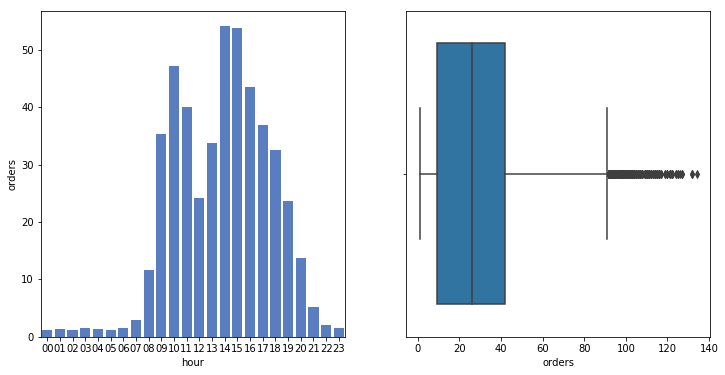

In [29]:
df2=df1[df1.hex_id=='87415cb48ffffff']
df3=df2.groupby('hour').agg({'orders':'mean'}).reset_index()
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.barplot(data=df3,x="hour",y="orders",color="b", ax=ax1)
ax2=ax[1] 
sns.boxplot(df2.orders,ax=ax2)

#### hex có lượng đơn trung bình cao ( 800k-1000k)

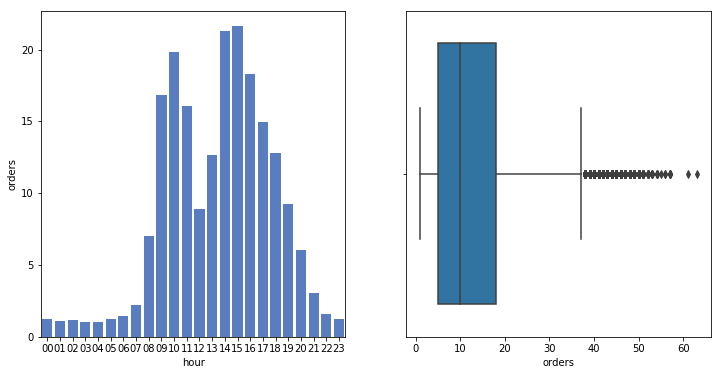

In [20]:
df2=df1[df1.hex_id=='87415cb49ffffff']
df3=df2.groupby('hour').agg({'orders':'mean'}).reset_index()
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.barplot(data=df3,x="hour",y="orders",color="b", ax=ax1)
ax2=ax[1] 
sns.boxplot(df2.orders,ax=ax2)

#### hex có lượng đơn trung bình thấp ( 300k-500k)

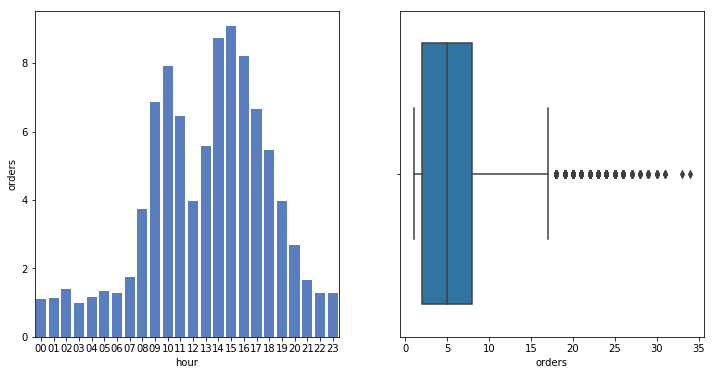

In [22]:

df2=df1[df1.hex_id=='87415cb6bffffff']
df3=df2.groupby('hour').agg({'orders':'mean'}).reset_index()
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.barplot(data=df3,x="hour",y="orders",color="b", ax=ax1)
ax2=ax[1] 
sns.boxplot(df2.orders,ax=ax2)

#### hex có lượng đơn thấp ( ~100k)

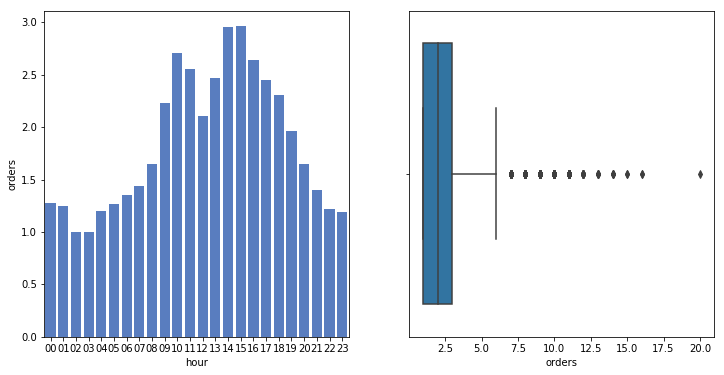

In [21]:

df2=df1[df1.hex_id=='87415cb59ffffff']
df3=df2.groupby('hour').agg({'orders':'mean'}).reset_index()
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.barplot(data=df3,x="hour",y="orders",color="b", ax=ax1)
ax2=ax[1] 
sns.boxplot(df2.orders,ax=ax2)

In [32]:
np.percentile(df1[df1.hex_id=='87415cb59ffffff'].orders, 95)

6.0

#### Bỏ 6 hex có lượng đơn thấp => giữ lại 15 hex ( vì 95% lượng đơn trong 10ph tại các khung giờ của các hex này đều ko thể vượt quá 6 đơn )

## Model: Dự báo demand của các hex trong 10min tới

### Model sử dụng:
#### - LightGBM (Lgbm)
#### - Long short-term memory (Lstm)
#### - XGBoost (Xgb)

### test các model trên các hex. Sử dụng RMSE để đánh giá kết quả của model

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [39]:
df=pd.read_parquet('./data_hex.parquet')
d = {'timebin': pd.date_range(start='2018-01-01', end='2019-08-23',freq='10T'),'value':0}
df4=pd.DataFrame(data=d)
df5=pd.read_parquet('./data_1.parquet')
df6=df4.merge(df5,how='left',on='timebin')
df6=df6.fillna(0)
df6=df6.drop(columns={'value'})
df6=df6.rename(columns={'order_all':'total_order'})
a=df.hex_id.drop_duplicates().tolist()

In [ ]:
rmse_lgbm=[]
rmse_lstm=[]
rmse_xgb=[]

for i in a:
    df=pd.read_parquet('./data_hex.parquet')
    df3=df[df.hex_id==i]
    df7=df3.merge(df6,how='right',on='timebin').sort_values('timebin')
    df8=df7.drop(columns='order_all')
    df8['hex_id']=df8.hex_id.fillna(i)
    df=df8.fillna(0)
    df['hour']=df.timebin.dt.strftime('%H')
    df['minute']=df.timebin.dt.strftime('%M')
    df['dow']=df.timebin.dt.strftime('%w')
    df['ss']=df['hour'].astype('float64')*60+df['minute'].astype('float64')
    df=df.sort_values('timebin')
    df['order_next']=df['orders'].shift(-1)

    ### lgbm model
    df1=df[df.timebin>='2018-01-01']
    df1=df1.drop(columns={'timebin','hex_id','distance'})
    df1=df1.astype('float64')
    df1=df1[(df1.hour>6)&(df1.hour<22)]
    X=df1.drop(['order_next'], axis=1)
    Y=df1[['order_next']]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7, shuffle=False)
    # fit model no training data
    params = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'root_mean_squared_error',
              'num_leaves': 10,
              'max_depth': 80,
              'learning_rate': 0.04,
              'bagging_fraction': 0.85,
              'feature_fraction': 1,
              'min_split_gain': 0.005,
              'min_child_samples': 150,
              'min_child_weight': 0.02,
              'lambda_l2': 0.05,
              'verbosity': 0,
              'data_random_seed': 17,
              'early_stop': 500,
              'verbose_eval': False,
              'num_rounds': 1000}
    # LightGBM dataset formatting 
    feature_names = X.columns.tolist()
    d_train = lgb.Dataset(X_train, y_train,
                    feature_name=feature_names)
    d_val = lgb.Dataset(X_test, y_test,
                    feature_name=feature_names)
    watchlist = [d_train, d_val]
    model = lgb.train(params,
        train_set=d_train,
        num_boost_round=params['num_rounds'],
        valid_sets=watchlist,
        verbose_eval=params['verbose_eval'],
        early_stopping_rounds=params['early_stop'])
    ythat=model.predict(X_test, num_iteration=model.best_iteration)
    a1=np.sqrt(mean_squared_error(y_test, ythat))
    rmse_lgbm.append(a1)

    #### XGB model
    x=df1.drop(['order_next'], axis=1)
    y=df1[['order_next']]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=False)
    model = xgb.XGBRegressor()
    model.fit(x_train,y_train)
    #Predict 
    ythat = model.predict(x_test)
    a2=np.sqrt(mean_squared_error(y_test, ythat))
    rmse_xgb.append(a2)

    #### lstm model
    df1=df[df.timebin>='2018-01-01']
    df1=df1.drop(columns={'timebin','hex_id','distance','order_next'})
    df1=df1.astype('float64')
    df1=df1[(df1.hour>6)&(df1.hour<22)]
    values=df1.values
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled=scaler.fit_transform(values)
    reframed=series_to_supervised(scaled, 1, 1)
    reframed=reframed.iloc[:,:11]
    X=reframed.iloc[:,:10]
    y=reframed.iloc[:,-1:]
    values = reframed.values
    train = values[:40432 ,:]
    test = values[40432:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.add(Activation('relu'))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=30, batch_size=90, verbose=0, shuffle=False)

    # PREDICT AND EVALUATE
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    a3 = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_lstm.append(a3)


In [43]:
data = {'hex_id': a, 'rmse_lgbm':rmse_lgbm ,'rmse_xgb': rmse_xgb,'rmse_lstm':rmse_lstm}
pd.DataFrame.from_dict(data)

,hex_id,rmse_lgbm,rmse_lstm,rmse_xgb
0,87415cb4effffff,6.787570,6.565653,6.932200
1,87415cb5dffffff,3.633385,3.728176,3.644293
2,87415cb4dffffff,5.441633,5.528160,5.473923
3,87415cb45ffffff,2.043219,3.827318,2.069484
4,87415cb4affffff,3.582084,3.770848,3.594317
5,874143696ffffff,3.339126,3.423149,3.357823
6,87415cb4cffffff,5.101987,21.753018,5.109425
7,87415cb48ffffff,8.023418,8.227573,8.341234
8,87415cb4bffffff,4.895806,5.035182,4.939946
9,87415cb6affffff,3.394131,3.580605,3.399717


#### Nhìn chung RMSE tương ứng với lượng đơn của từng hex( RMSE trải dài từ 1-8). Đối với hex nhiều đơn nhất (87415cb48ffffff) có RMSE lớn nhất ~ 8.
#### - Kết quả của từng model không khác nhau nhiều ( chênh lệch <1) vì vậy:
####    + Dùng chung 1 thuật toán để sử dụng
####    + Áp dụng LGBM để áp dụng (vì phần lớn kết quả của LGBM trên các hex đều tốt hơn dù không nhiều)

### Add new features: lượng đơn của các mốc time trước đó

In [ ]:
rmse_lgbm=[]
rmse_lstm=[]
rmse_xgb=[]

for i in a:
    df=pd.read_parquet('./data_hex.parquet')
    df3=df[df.hex_id==i]
    df7=df3.merge(df6,how='right',on='timebin').sort_values('timebin')
    df8=df7.drop(columns='order_all')
    df8['hex_id']=df8.hex_id.fillna(i)
    df=df8.fillna(0)
    df['hour']=df.timebin.dt.strftime('%H')
    df['minute']=df.timebin.dt.strftime('%M')
    df['dow']=df.timebin.dt.strftime('%w')
    df['ss']=df['hour'].astype('float64')*60+df['minute'].astype('float64')
    df=df.sort_values('timebin')
    df['order_next']=df['orders'].shift(-1)
    df['order_1']=df['orders'].shift(1)
    df['order_2']=df['orders'].shift(2)
    df['order_3']=df['orders'].shift(3)
    df['order_4']=df['orders'].shift(4)
    df['order_5']=df['orders'].shift(5)

    ### lgbm model
    df1=df[df.timebin>='2018-01-01']
    df1=df1.drop(columns={'timebin','hex_id','distance'})
    df1=df1.astype('float64')
    df1=df1[(df1.hour>6)&(df1.hour<22)]
    X=df1.drop(['order_next'], axis=1)
    Y=df1[['order_next']]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7, shuffle=False)
    # fit model no training data
    params = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'root_mean_squared_error',
              'num_leaves': 10,
              'max_depth': 80,
              'learning_rate': 0.04,
              'bagging_fraction': 0.85,
              'feature_fraction': 1,
              'min_split_gain': 0.005,
              'min_child_samples': 150,
              'min_child_weight': 0.02,
              'lambda_l2': 0.05,
              'verbosity': 0,
              'data_random_seed': 17,
              'early_stop': 500,
              'verbose_eval': False,
              'num_rounds': 1000}
    # LightGBM dataset formatting 
    feature_names = X.columns.tolist()
    d_train = lgb.Dataset(X_train, y_train,
                    feature_name=feature_names)
    d_val = lgb.Dataset(X_test, y_test,
                    feature_name=feature_names)
    watchlist = [d_train, d_val]
    model = lgb.train(params,
        train_set=d_train,
        num_boost_round=params['num_rounds'],
        valid_sets=watchlist,
        verbose_eval=params['verbose_eval'],
        early_stopping_rounds=params['early_stop'])
    ythat=model.predict(X_test, num_iteration=model.best_iteration)
    a1=np.sqrt(mean_squared_error(y_test, ythat))
    rmse_lgbm.append(a1)

    #### XGB model
    x=df1.drop(['order_next'], axis=1)
    y=df1[['order_next']]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=False)
    model = xgb.XGBRegressor()
    model.fit(x_train,y_train)
    #Predict 
    ythat = model.predict(x_test)
    a2=np.sqrt(mean_squared_error(y_test, ythat))
    rmse_xgb.append(a2)

In [45]:
data = {'hex_id': a, 'rmse_lgbm':rmse_lgbm ,'rmse_xgb':rmse_xgb}
pd.DataFrame.from_dict(data)

,hex_id,rmse_lgbm,rmse_xgb
0,87415cb4effffff,6.401656,6.607124
1,87415cb5dffffff,3.591080,3.600761
2,87415cb4dffffff,5.347011,5.392399
3,87415cb45ffffff,2.019575,2.045131
4,87415cb4affffff,3.558473,3.585277
5,874143696ffffff,3.265353,3.297809
6,87415cb4cffffff,5.039045,5.059543
7,87415cb48ffffff,7.659774,8.060918
8,87415cb4bffffff,4.837786,4.895212
9,87415cb6affffff,3.258934,3.274825


#### Khi thêm feature mới RMSE tại các hex đều giảm xuống mặc dù chưa nhiều ( giảm 0.5-1)

#### Sử dụng feature selection và tuning parameters đối với LightGBM kết quả cũng ko khác biệt

### Visualization kết quả của các model với hex có nhiều đơn nhất(87415cb48ffffff)

#### - LGBM

In [49]:
df=pd.read_parquet('./data_hex.parquet')
df3=df[df.hex_id=='87415cb48ffffff']
df7=df3.merge(df6,how='right',on='timebin').sort_values('timebin')
df8=df7.drop(columns='order_all')
df8['hex_id']=df8.hex_id.fillna('87415cb48ffffff')
df=df8.fillna(0)
df['hour']=df.timebin.dt.strftime('%H')
df['minute']=df.timebin.dt.strftime('%M')
df['dow']=df.timebin.dt.strftime('%w')
df['ss']=df['hour'].astype('float64')*60+df['minute'].astype('float64')
df=df.sort_values('timebin')
df['order_next']=df['orders'].shift(-1)
df['order_1']=df['orders'].shift(1)
df['order_2']=df['orders'].shift(2)
df['order_3']=df['orders'].shift(3)
df['order_4']=df['orders'].shift(4)
df['order_5']=df['orders'].shift(5)

### lgbm model
df1=df[df.timebin>='2018-01-01']
df1=df1.drop(columns={'timebin','hex_id','distance'})
df1=df1.astype('float64')
df1=df1[(df1.hour>6)&(df1.hour<22)]
X=df1.drop(['order_next'], axis=1)
Y=df1[['order_next']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7, shuffle=False)
# fit model no training data
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'root_mean_squared_error',
          'num_leaves': 10,
          'max_depth': 80,
          'learning_rate': 0.04,
          'bagging_fraction': 0.85,
          'feature_fraction': 1,
          'min_split_gain': 0.005,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.05,
          'verbosity': 0,
          'data_random_seed': 17,
          'early_stop': 500,
          'verbose_eval': False,
          'num_rounds': 1000}
# LightGBM dataset formatting 
feature_names = X.columns.tolist()
d_train = lgb.Dataset(X_train, y_train,
                feature_name=feature_names)
d_val = lgb.Dataset(X_test, y_test,
                feature_name=feature_names)
watchlist = [d_train, d_val]
model = lgb.train(params,
    train_set=d_train,
    num_boost_round=params['num_rounds'],
    valid_sets=watchlist,
    verbose_eval=params['verbose_eval'],
    early_stopping_rounds=params['early_stop'])
ythat=model.predict(X_test, num_iteration=model.best_iteration)
y_test['ythat']=ythat

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


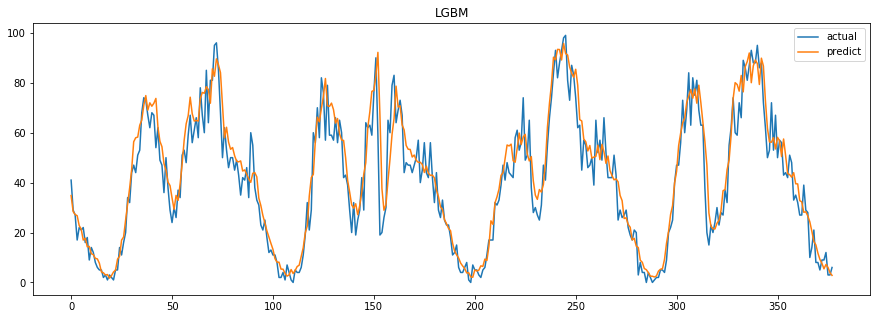

In [53]:

plt.figure(figsize=(15, 5))
plt.plot(y_test[13100:]['order_next'].tolist(), label='actual')
plt.plot(y_test[13100:]['ythat'].tolist(), label='predict')
plt.title("LGBM")
plt.legend()

#### -XGB

In [58]:
x=df1.drop(['order_next'], axis=1)
y=df1[['order_next']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=False)
model = xgb.XGBRegressor()
model.fit(x_train,y_train)
#Predict 
ythat = model.predict(x_test)
y_test['ythat']=ythat

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


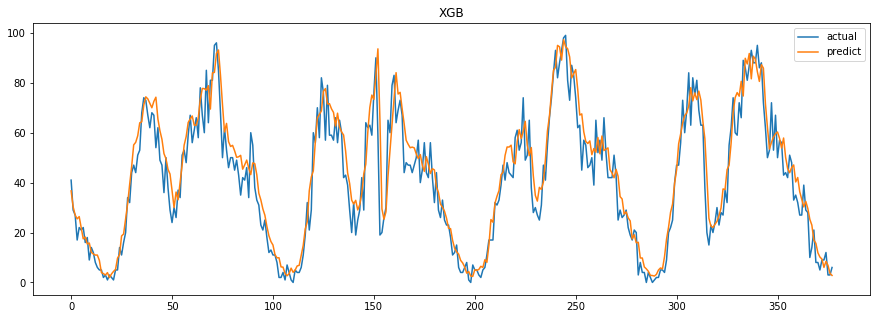

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(y_test[13100:]['order_next'].tolist(), label='actual')
plt.plot(y_test[13100:]['ythat'].tolist(), label='predict')
plt.title("XGB")
plt.legend()

#### - LSTM

In [62]:
df=pd.read_parquet('./data_hex.parquet')
df3=df[df.hex_id=='87415cb48ffffff']
df7=df3.merge(df6,how='right',on='timebin').sort_values('timebin')
df8=df7.drop(columns='order_all')
df8['hex_id']=df8.hex_id.fillna('87415cb48ffffff')
df=df8.fillna(0)
df['hour']=df.timebin.dt.strftime('%H')
df['minute']=df.timebin.dt.strftime('%M')
df['dow']=df.timebin.dt.strftime('%w')
df['ss']=df['hour'].astype('float64')*60+df['minute'].astype('float64')
df=df.sort_values('timebin')
df['order_next']=df['orders'].shift(-1)
df1=df[df.timebin>='2018-01-01']
df1=df1.drop(columns={'timebin','hex_id','distance','order_next'})
df1=df1.astype('float64')
df1=df1[(df1.hour>6)&(df1.hour<22)]
values=df1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
reframed=series_to_supervised(scaled, 1, 1)
reframed=reframed.iloc[:,:11]
X=reframed.iloc[:,:10]
y=reframed.iloc[:,-1:]
values = reframed.values
train = values[:40432 ,:]
test = values[40432:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Activation('relu'))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=90, verbose=0, shuffle=False)

# PREDICT AND EVALUATE
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


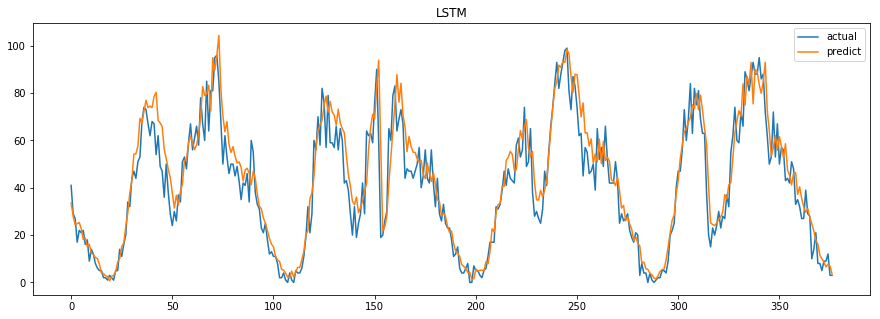

In [65]:
f,ax=plt.subplots(figsize=(15,5))
plt.plot(inv_y[13100:],label="actual")
plt.plot(inv_yhat[13100:], label='predict')
plt.title("LSTM")
plt.legend()

### Visualize in map

In [75]:
a=df_hexagon[['hex','geometry','type']].to_dict('records')
b={"type":"FeatureCollection","features":a}
import sys
sys.path.insert(0,'folium')
import folium
# import folium.plugins
from folium.features import *
df_result=df11.copy()
from h3 import h3
df_result['latlng']=df_result['hex_id'].apply(lambda x: h3.h3_to_geo(x))

In [76]:
class DivIcon(MacroElement):
    def __init__(self, html='', size=(1,1), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

In [80]:
df_result

,hex_id,ythat,density,latlng
0,87415cb4effffff,51.0,40->70,"[21.023057238987324, 105.84590766810639]"
1,87415cb5dffffff,19.0,6->20,"[21.044773366803803, 105.85306398768749]"
2,87415cb4dffffff,42.0,40->70,"[20.99684251115526, 105.81473266655036]"
3,87415cb45ffffff,4.0,0->6,"[20.98859447323195, 105.87962685265047]"
4,87415cb4affffff,23.0,20->40,"[21.040285549103082, 105.82904279945762]"
5,874143696ffffff,13.0,6->20,"[21.031297575461778, 105.78099293061699]"
6,87415cb4cffffff,38.0,20->40,"[21.00133674811169, 105.8387520945259]"
7,87415cb48ffffff,76.0,70->100,"[21.018566210426812, 105.8218873596555]"
8,87415cb4bffffff,39.0,20->40,"[21.035793618462396, 105.80501911108146]"
9,87415cb6affffff,14.0,6->20,"[20.98410523898556, 105.85561331386911]"


In [81]:
m_bike=folium.Map(location=[21.0207,105.8321],zoom_start=11)
bins = [0,6,20,40,70,150]
m_bike.choropleth(
 geo_data=b,
 name='choropleth',
 data=df_result,
 columns=['hex_id', 'ythat'],
 key_on='feature.hex',
 fill_color='RdPu',
 fill_opacity=0.8,
 line_opacity=1,
 legend_name='density',
 threshold_scale=bins)

In [82]:
m_bike

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')